# Cài đặt các thư viện cần thiết

In [3]:
!pip install --upgrade gensim
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install gensim

Requirement already up-to-date: gensim in /home/hai/anaconda3/lib/python3.8/site-packages (4.0.1)


# Load data, visualize data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [5]:
# Đọc dữ liệu từ file csv link tải: https://www.kaggle.com/uciml/sms-spam-collection-dataset
df = pd.read_csv("spam.csv", header=0, encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Số lượng thư ham và spam

In [6]:
data = df['v2'].values
label = df['v1'].values
label_split = Counter(label)
label_split

Counter({'ham': 4825, 'spam': 747})

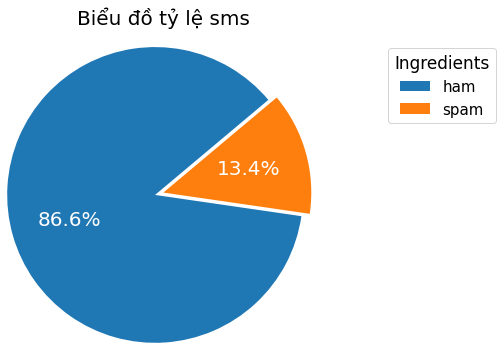

In [7]:
# visualize data
listdata = np.array([label_split['ham']/(len(df)), label_split['spam']/len(df)])
name_labels = ['ham', 'spam']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(listdata, labels=name_labels , 
      #  shadow=True, 
       explode = (0.1, 0), 
       labeldistance=None, 
       radius=1.7, startangle=40, 
       autopct='%1.1f%%',
       textprops={'size': '20', "color": "w"})

ax.legend(wedges, name_labels,
          title = 'Ingredients',
          loc='best',
          bbox_to_anchor=(1.5, 0.7, 0, 0.5),
          fontsize='15',
          title_fontsize='17')
ax.set_title('Biểu đồ tỷ lệ sms', pad=60, fontdict={'size': '20', 'color': 'black'})
plt.show()

# Tiền xử lý dữ liệu

In [11]:
import re
from gensim.parsing.preprocessing import strip_numeric, strip_non_alphanum, split_alphanum, strip_short
def Processing(word):
  # xóa các đường dẫn
  word = re.sub(r"http\S+", "", word)
  # xóa các dấu câu, các ký tự lạ
  word = strip_non_alphanum(word).lower().strip()
  # tách các từ vô nghĩa (b1 => b 1)
  word = split_alphanum(word)
  # xóa các ký tự đúng 1 mình
  word = strip_short(word)
  # xóa các số trong word
  word = strip_numeric(word)
  return word
def bag_of_word(doc):
  bag = []
  for word in doc:
    bag += Processing(word).split(' ')
  bag = list(set(bag))
  if ' ' in bag:
    bag.remove(' ')
  if '' in bag:
    bag.remove('')
  
  return bag

# Xây dựng model

## Tạo hàm train_test_split, và hàm vector hóa các tin nhắn

In [12]:
# chi train-test ngẫu nhiên theo tỷ lệ train_size, defaul: train_size = 0.8
def train_test_split(data, label, train_size = 0.8):
  X_train, X_test = [], []
  y_train, y_test = [], []

  len_train_ham = int(len(label[label == 'ham'])*train_size)
  len_train_spam = int(len(label[label == 'spam'])*train_size)
  index = np.arange(len(data))
  np.random.shuffle(index)
  count_ham, count_spam = 0, 0
  for i in index:
    if (label[index[i]] == 'ham'):
      if (count_ham < len_train_ham):
        X_train.append(data[index[i]])
        y_train.append('ham')
        count_ham += 1
      else:
        X_test.append(data[index[i]])
        y_test.append('ham')
    else:
      if (count_spam < len_train_spam):
        X_train.append(data[index[i]])
        y_train.append('spam')
        count_spam += 1
      else:
        X_test.append(data[index[i]])
        y_test.append('spam')
  
  X_train, X_test = np.array(X_train), np.array(X_test)
  y_train, y_test = np.array(y_train), np.array(y_test)

  return (X_train, X_test, y_train, y_test)

def vector_words(data, bag_word):
  data_ = []
  for node in data:
    x = np.zeros((len(bag_word), ))
    node_pross = Processing(node)
    for i, word in enumerate(bag_word):
      if word in node_pross:
        x[i] = 1
    data_.append(x.copy())
  data_ = np.array(data_)
  return data_


## Chạy thực nghiệm 

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

test_size = 0.2
alpha = 0.1

# Vector hoa du lieu
X_word_train, X_word_test, y_word_train, y_word_test = train_test_split(data, label, train_size=1-test_size)
bag_word = bag_of_word(X_word_train)

X_train, X_test = vector_words(X_word_train, bag_word), vector_words(X_word_test, bag_word)
le = LabelEncoder()
le.fit(['ham', 'spam'])
y_train = le.transform(y_word_train)
y_test = le.transform(y_word_test)

# Run model
clf = MultinomialNB(alpha=alpha)
clf.fit(X_train, y_train)


# clf.score(X_test, y_test)
y_predict = clf.predict(X_test)
# Đánh giá model với alpha = 0.1, thay đổi giá trị alpha để có giá trị khác nhau
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       965
           1       0.90      0.92      0.91       150

    accuracy                           0.98      1115
   macro avg       0.94      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115

